# Weighting, Matching, or Regression?

*Comparing different methods to condition causal inference on covariates*

INTRO

## Example

Assume we were a firm interested in understanding the effect of $D$ on $Y$. Unfortunately, we cannot randomize $D$. Unfortunately we cannot randomize $D$. 

We can represent the data generating process with the following [**Directed Acyclic Graph (DAG)**](https://towardsdatascience.com/b63dc69e3d8c). If you are not familiar with DAGs, I have written a short [introduction here](https://towardsdatascience.com/b63dc69e3d8c).

```mermaid
flowchart TB
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

X1((gender))
X2((age))
X3((income))
D((treatment))
Y((outcome))

D --> Y
X1 --> Y
X1 --> D
X2 --> D
X2 --> Y
X3 --> D
X3 --> Y

class D,Y included;
class X1,X2,X3 excluded;
```

We can now generate the simulated data, using the data generating process `dgp_ipw()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). I also import some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_ipw

In [3]:
df = dgp_ipw().generate_data()
df.head()

,outcome,treated,male,age,income
0,21.10,False,0,39.0,2035.0
1,38.49,True,1,22.0,1384.0
2,23.69,False,0,22.0,1361.0
3,32.24,False,0,32.0,2942.0
4,31.43,True,0,47.0,2426.0


We have informations on 1000 individuals indexed by `i` for whom we observe the revenue generated pre and post treatment, `revenue0` and `revenue1` respectively, and whether they have been exposed to the `ad_campaign`.

Are the covariates balanced?

In [4]:
from causalml.match import create_table_one

X = ['outcome', 'male', 'age', 'income']
table1 = create_table_one(df, 'treated', X)
table1

,Control,Treatment,SMD
Variable,,,
n,477,523,
age,32.65 (8.19),31.71 (8.53),-0.1134
income,1910.63 (613.70),1921.11 (551.87),0.018
male,0.43 (0.50),0.57 (0.50),0.2779
outcome,23.14 (5.37),28.64 (5.15),1.0442


Another way to visually observe all the differences at once is with a paired violinplot.

In [5]:
def plot_distributions(df, X):
    df_long = df.copy()
    df_long[X] =(df_long[X] - df_long[X].mean()) / df_long[X].std()
    df_long = pd.melt(df_long, id_vars='treated', value_name='value')
    sns.violinplot(y="variable", x="value", hue="treated", data=df_long, palette="muted", split=True).\
        set(xlabel="", ylabel="", title="Normalized Variable Distribution");

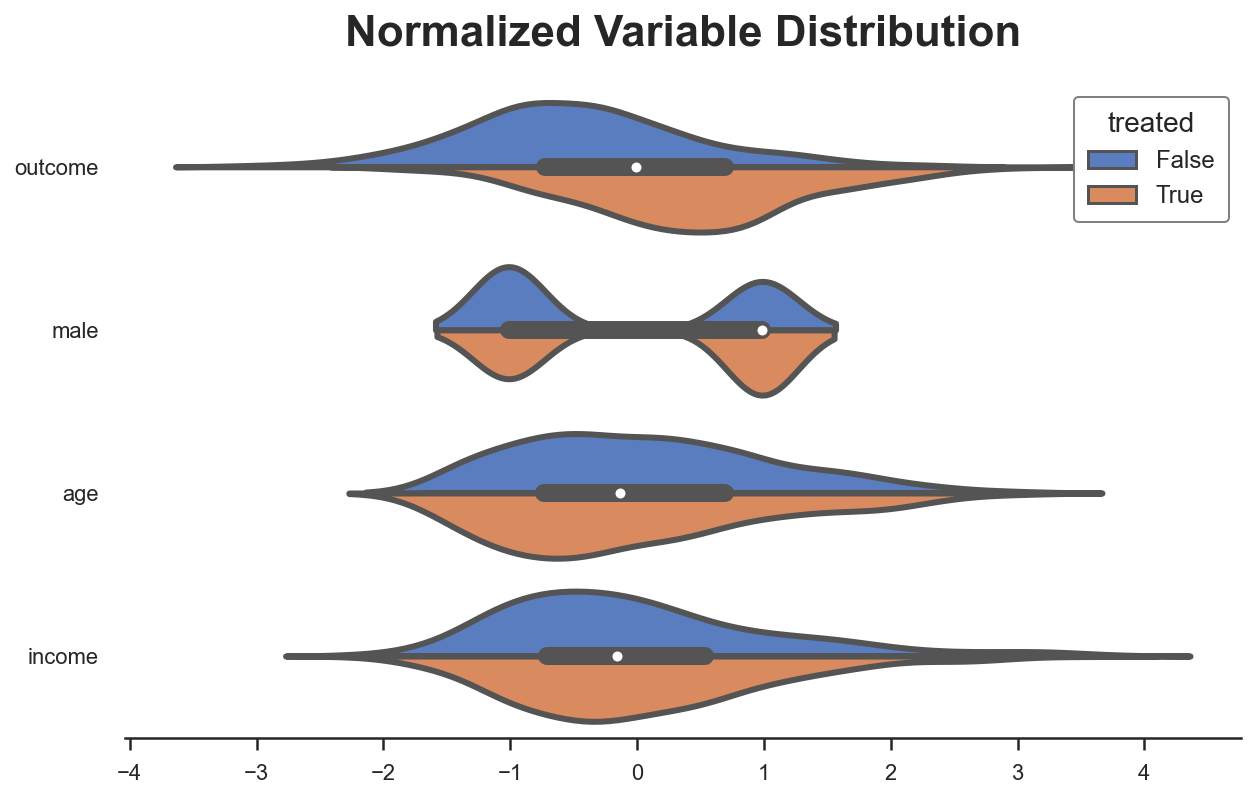

In [6]:
plot_distributions(df, X)

If we do not control for the observable characteristics, we are unable to estimate the true treatment effect.

```mermaid
flowchart TB
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

X1((gender))
X2((age))
X3((income))
D((treatment))
Y((outcome))

D --> Y
X1 --> Y
X1 --> D
X2 --> D
X2 --> Y
X3 --> D
X3 --> Y

linkStyle 0 stroke:#00ff00,stroke-width:4px;
linkStyle 1,2,3,4,5,6 stroke:#ff0000,stroke-width:4px;
class D,Y included;
class X1,X2,X3 excluded;
```

By controlling for observable characteristics, we "block" the backdoor paths and we are able to recover the causal effect of $D$ on $Y$.

```mermaid
flowchart TB
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

X1((gender))
X2((age))
X3((income))
D((treatment))
Y((outcome))

D --> Y
X1 -.-> Y
X1 -.-> D
X2 -.-> D
X2 -.-> Y
X3 -.-> D
X3 -.-> Y

linkStyle 0 stroke:#00ff00,stroke-width:4px;
class D,Y,X1,X2,X3 included;
```

How do we do it? We have some options:

- Matching
- Propensity score weighting
- Regression with control variables

How do the methods work and what are the differences?

## Theory

We assume that for a set of i.i.d. subjects $i = 1, ..., n$ we observed a tuple $(X_i, T_i, Y_i)$ comprised of 

- a feature vector $X_i \in \mathbb R^n$
- a treatment assignment $T_i \in \lbrace 0, 1 \rbrace$
- a response $Y_i \in \mathbb R$

**Assumption 1 : unconfoundedness** (or ignorability, or selection on observables)

$$
\big \lbrace Y_i^{(1)} , Y_i^{(0)} \big \rbrace \ \perp \ T_i \ | \ X_i
$$

i.e. conditional on observable characteristics $X$, the treatment assignment $T$ is as good as random.

**Assumption 2: overlap** (or bounded support)

$$
\exists \eta > 0 \ : \ \eta \leq \mathbb E \left[ T_i = 1 \ \big | \ X_i = x \right] \leq 1-\eta
$$

i.e. no observation is deterministically assigned to the treatment or control group. 

## Matching

In [7]:
from causalml.match import NearestNeighborMatch, create_table_one

psm = NearestNeighborMatch(replace=True, ratio=1, random_state=42)
df_matched = psm.match(data=df, 
                       treatment_col="treated",
                       score_cols=X)
df_matched.head()

,outcome,treated,male,age,income
5,29.55,True,0,29.0,1830.0
7,37.08,True,0,24.0,1723.0
8,30.06,True,0,34.0,1819.0
9,28.58,True,1,30.0,2565.0
11,32.55,True,1,27.0,2172.0


In [8]:
table1_matched = create_table_one(df_matched, 'treated', X)
table1_matched

,Control,Treatment,SMD
Variable,,,
n,304,304,
age,30.66 (7.19),30.58 (7.23),-0.0109
income,1809.42 (424.97),1813.98 (425.19),0.0107
male,0.55 (0.50),0.55 (0.50),0.0
outcome,26.67 (4.40),26.85 (4.38),0.0403


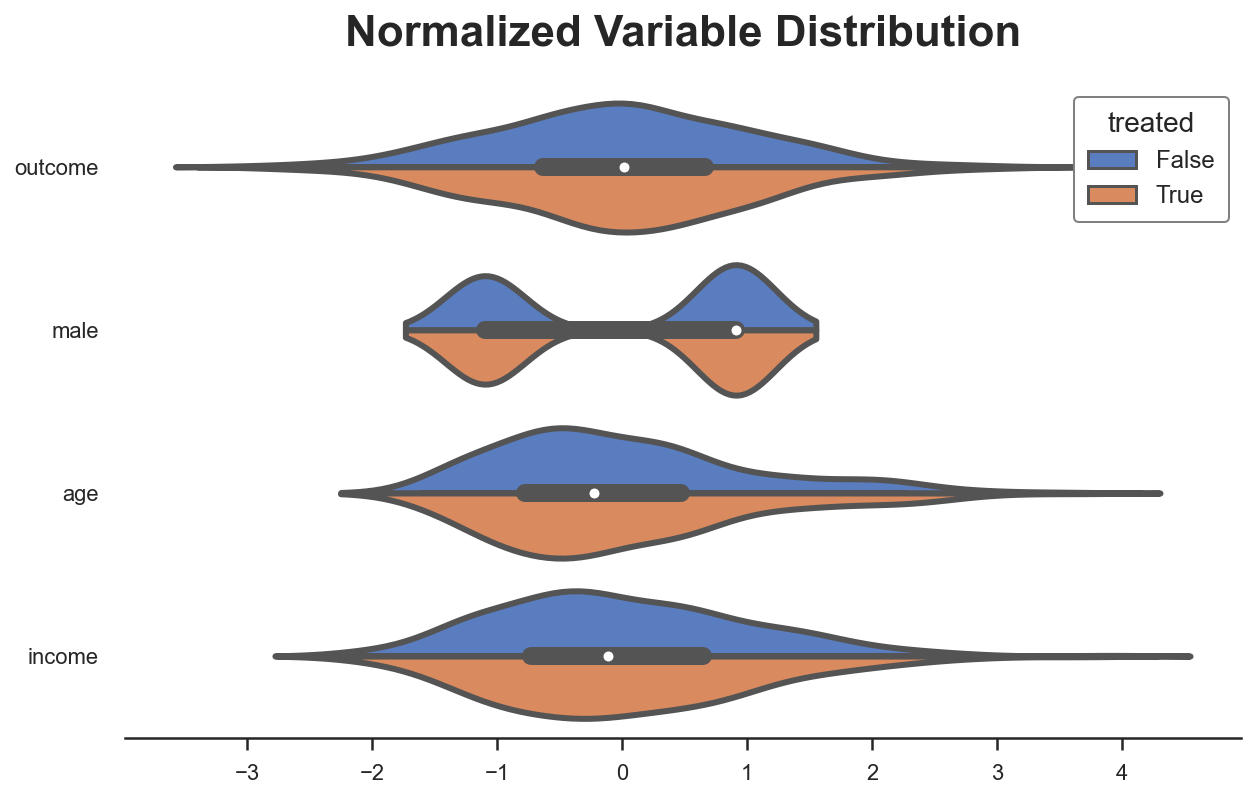

In [9]:
plot_distributions(df_matched, X)

We can also compare the balancedness before and after matching by plotting the standardized mean differences.

In [12]:
def plot_balance(t1, t2, X):
    df_smd = pd.DataFrame({"Variable": X + X,
                           "Data": ["Original" for _ in range(len(X))] + ["Matched" for _ in range(len(X))],
                           "Standardized Mean Difference": t1["SMD"][1:].to_list() + 
                                                           t2["SMD"][1:].to_list()})

    sns.scatterplot(x="Standardized Mean Difference", y="Variable", hue="Data", data=df_smd).\
        set(title="Balance Plot")
    plt.axvline(x=0, color='k', ls='--', zorder=-1, alpha=0.3);

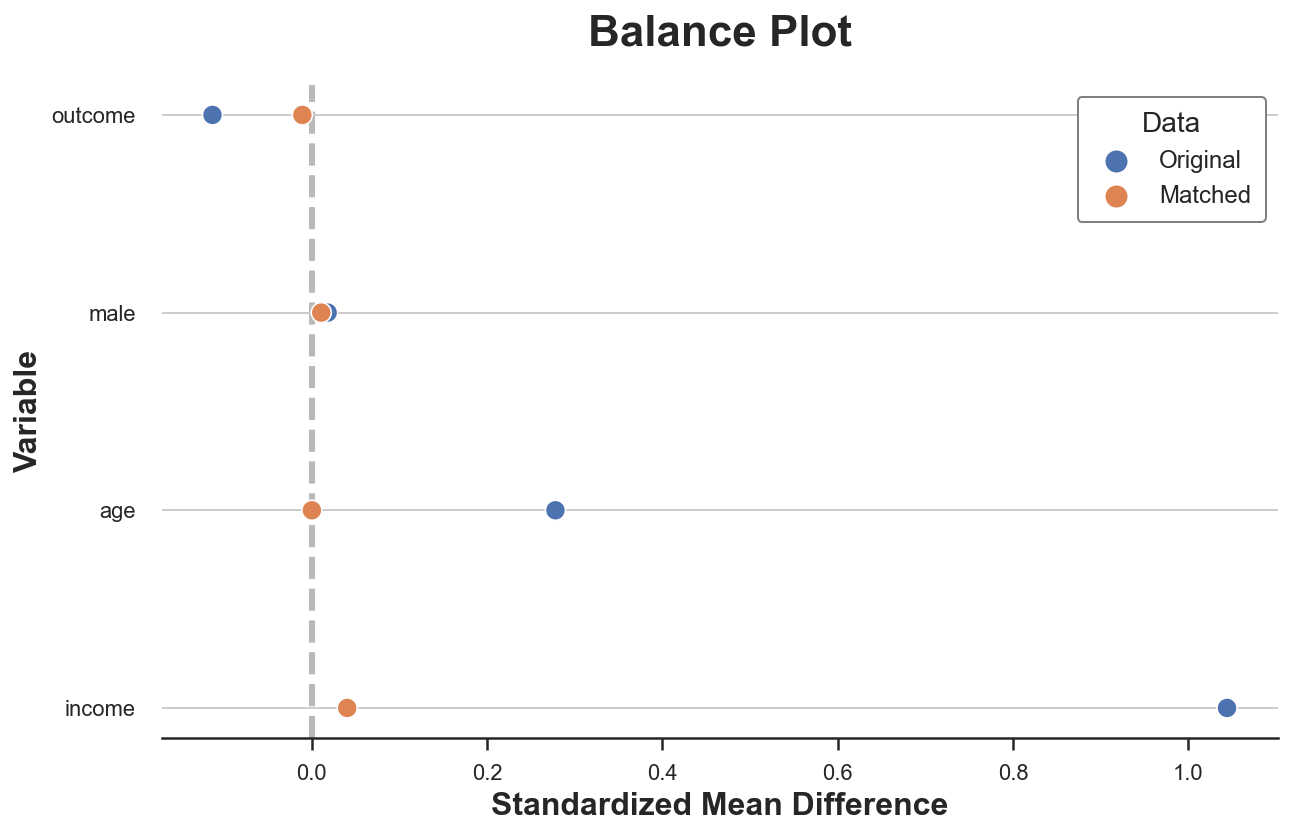

In [13]:
plot_balance(table1, table1_matched, X)

## Propensity Score

We want to estimate the **average treatment effect**

$$
\tau(x) = \mathbb E \left[ Y^{(1)} - Y^{(0)} \ \big| \ X = x \right]
$$

We would like to obtain an unbiased estimator that satifies a central limit theorem of the form

$$
\sqrt{n} ( \hat \tau - \tau) \ \overset{d}{\to} \ N(0, V)
$$

thus enabling us to construct **confidence intervals**.

Under **unconfoundedness**, we can rewrite the average treatment effect as

$$
\tau(x) = \mathbb E \left[ Y^{(1)} - Y^{(0)} \ \big| \ X = x \right] = \mathbb E \left[ \frac{T_i Y_i}{e(X_i)} - \frac{(1-T_i) Y_i}{1-e(X_i)} \right]
$$

where $e(X_i)$ is the **propensity score** of observation $i$, 

$$
e(x) = \mathbb P \left[ T_i = 1 \ \big | \ X_i = x \right]
$$

i.e. its probability of being treated.

Note that this formulation of the average treatment effect does not depend on the potential outcomes $Y_i^{(1)}$ and $Y_i^{(0)}$, but only on the observed outcomes $Y_i$.

This formulation of the average treatment effect implies the **Inverse Propensity Weighted** estimator which is an unbiased estimator for the average treatment effect $\tau$ 

$$
\hat \tau^{*}_{IPW} = \frac{1}{n} \sum _ {i=1}^{n} \left( \frac{T_i Y_i}{e(X_i)} - \frac{(1-T_i) Y_i}{1-e(X_i)} \right)
$$

However, this estimator is **unfeasible** since we do not observe the propensity scores $e(X_i)$.

## Conclusion

TBD

### References

TBD

### Related Articles

- [Understanding The Frisch-Waugh-Lovell Theorem](https://towardsdatascience.com/59f801eb3299)
- [Understanding Contamination Bias](https://towardsdatascience.com/58b63d25d2ef)
- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/ipw.ipynb